In [1]:
import sys
import pathlib as pl
sys.path.insert(0,str(pl.Path(".").absolute()))

In [2]:
from Transformer.transformer import TransformerTranslator
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

generate data


In [20]:
seq_size = 100
token_size = 10
num_blocks = 2
num_heads = 2  # Must be factor of token size
vocab_size = 5
max_context_length = 1000

x_nums = np.random.rand(seq_size) * (vocab_size - 2)  # Not Used
y_nums = np.random.rand(seq_size) * (vocab_size - 2)
z_nums = np.random.rand(seq_size) * (vocab_size - 2)  # Not Used

x = np.zeros((seq_size))
y = np.zeros((seq_size))
z = np.zeros((seq_size))
for idx, item in enumerate(x_nums):
    x[idx] = abs(int(item)) + 1
for idx, item in enumerate(y_nums):
    y[idx] = abs(int(item)) + 1
for idx, item in enumerate(z_nums):
    z[idx] = abs(int(item)) + 1

x = torch.from_numpy(x).type(torch.LongTensor)
y = torch.from_numpy(y).type(torch.LongTensor)
z = torch.from_numpy(z).type(torch.LongTensor)


import matplotlib.pyplot as plt


def plot_data(x, y, title):
    plt.cla()
    plt.clf()
    fig, ax = plt.subplots()
    ax.set_title(str(title))
    fig.dpi = 100.0
    plt.xlim([0, seq_size])
    plt.ylim([0, vocab_size])
    plt.plot(x)
    plt.plot(y)
    #plt.savefig(str(epoch) + ".png")

<Figure size 640x480 with 0 Axes>

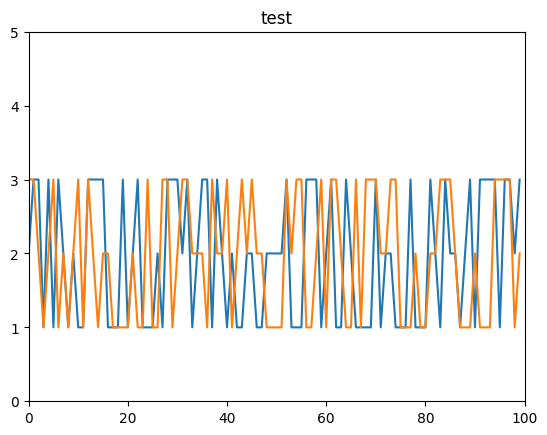

In [22]:
plot_data(x,z,"test")

Train Data

In [26]:
y.unsqueeze(0).shape, y.shape

(torch.Size([1, 100]), torch.Size([100]))

In [40]:
epoch_num = 100
net = TransformerTranslator(token_size, num_blocks, num_heads, vocab_size,vocab_size)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
criterion = nn.MSELoss()

for i in range(epoch_num):
    outs = []
    avg_loss = []

    # y as input data
    ix = y.unsqueeze(0)
    net.zero_grad()
    optimizer.zero_grad()

    torch_outs = None
    iy_label_outs = None
    iy_label_outs_args = torch.tensor([], requires_grad=False, dtype=torch.int64)

    _ = net.encode(ix)  # encode does not return encoding but stores it in hidden transformer state
    
    # generate transformer predictions, next prediction stepwise each, based on previous true label.
    for interval_jdx in range(1, 101):
        # load previous labels
        if interval_jdx != 1:
            iy = iy_label_outs_args  # y[:interval_jdx]
        else:
            iy = torch.tensor([0], dtype=torch.int64)
        
        # Predict next token
        # output is predicted class = token, thus a vector
        iy = iy.unsqueeze(0)
        out = net.forward(iy)

        # read true label from index
        iy_label_raw = np.zeros((vocab_size), dtype=np.float32)
        iy_label_raw[y[interval_jdx - 1]] = 1
        iy_label = torch.from_numpy(iy_label_raw).unsqueeze(0)

        if interval_jdx != 1:
            torch_outs = torch.cat((torch_outs, out), dim=1)
            iy_label_outs = torch.cat((iy_label_outs, iy_label), dim=0)
        else:
            torch_outs = out
            iy_label_outs = iy_label
        iy_label_outs_args = torch.cat(
            (iy_label_outs_args, torch.tensor([torch.argmax(out)], dtype=torch.int64)),
            dim=0,
        )
        outs.append(torch.argmax(out.detach()))
    # iy_label_outs are a list of predicted classes (predicted class is vector itself)
    # torch_outs has additional dimension which is empty.
    loss = criterion(iy_label_outs, torch_outs[0])
    loss.backward()
    optimizer.step()
    print("MEAN LOSS: {}".format(i), loss.item())

torch.Size([1, 100, 5])
MEAN LOSS: 0 4.016912937164307
torch.Size([1, 100, 5])
MEAN LOSS: 1 3.744682550430298
torch.Size([1, 100, 5])
MEAN LOSS: 2 3.6822457313537598
torch.Size([1, 100, 5])
MEAN LOSS: 3 3.665282964706421
torch.Size([1, 100, 5])
MEAN LOSS: 4 3.6106455326080322
torch.Size([1, 100, 5])
MEAN LOSS: 5 3.6112258434295654
torch.Size([1, 100, 5])
MEAN LOSS: 6 3.559422492980957
torch.Size([1, 100, 5])
MEAN LOSS: 7 3.526304244995117
torch.Size([1, 100, 5])
MEAN LOSS: 8 3.459454298019409
torch.Size([1, 100, 5])
MEAN LOSS: 9 3.4641239643096924
torch.Size([1, 100, 5])
MEAN LOSS: 10 3.4838857650756836
torch.Size([1, 100, 5])
MEAN LOSS: 11 3.4885265827178955
torch.Size([1, 100, 5])
MEAN LOSS: 12 3.500502586364746
torch.Size([1, 100, 5])
MEAN LOSS: 13 3.4743993282318115
torch.Size([1, 100, 5])
MEAN LOSS: 14 3.4621992111206055
torch.Size([1, 100, 5])
MEAN LOSS: 15 3.454153299331665
torch.Size([1, 100, 5])
MEAN LOSS: 16 3.4409613609313965
torch.Size([1, 100, 5])
MEAN LOSS: 17 3.439894914

In [5]:



import random

for i in range(1):
    outs = []
    avg_loss = []
    ix = y.unsqueeze(0)
    torch_outs = None
    iy_label_outs = None
    iy_label_outs_args = torch.tensor([], requires_grad=False, dtype=torch.int64).to("cuda:0")
    _ = net.encode(ix)
    for interval_jdx in range(1, 101):
        if interval_jdx != 1:
            iy = iy_label_outs_args  # y[:interval_jdx]
        else:
            iy = torch.tensor([0], dtype=torch.int64)
        # Predict next token
        iy = iy.unsqueeze(0)
        out = net.forward(iy)

        iy_label_raw = np.zeros((vocab_size))
        iy_label_raw[y[interval_jdx - 1]] = 1
        iy_label = torch.tensor((iy_label_raw), requires_grad=True).unsqueeze(0)

        if interval_jdx != 1:
            torch_outs = torch.cat((torch_outs, out), dim=1)
            iy_label_outs = torch.cat((iy_label_outs, iy_label), dim=0)
        else:
            torch_outs = out
            iy_label_outs = iy_label

        iy_label_outs_args = torch.cat(
            (iy_label_outs_args, torch.tensor([torch.argmax(out)], dtype=torch.int64)),
            dim=0,
        )
        outs.append(torch.argmax(out.detach()))

    loss = criterion(iy_label_outs, torch_outs)
    print("MEAN LOSS TEST: {}".format(i), loss)
plot_data(y, outs, "Test")

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!